In [2]:
import numpy as np
import matplotlib.pyplot as plt
import solver.simple_hrl_solver as solver

from scipy.optimize import fsolve, curve_fit
import joblib as jl
import json
import glob
import matplotlib.cm as cm
import seaborn as sns
import os

'\nfor k,v in score_dic.items():\n    print(k, V_timescale(VT0, VS0, R= v[0], T=k))\n'

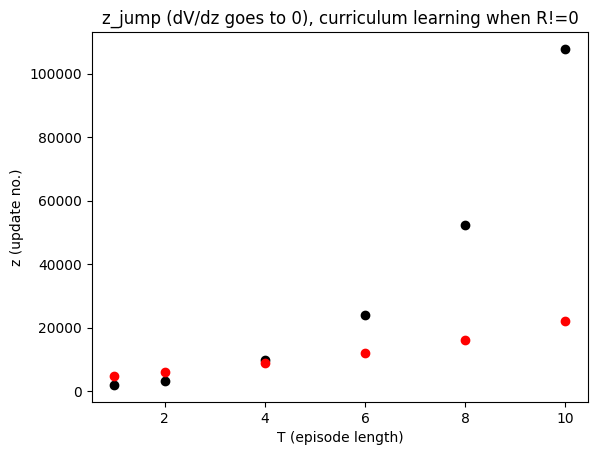

In [5]:
def load_log(p):
    log =jl.load(p)
    args = json.load(open('/'.join(p.split('/')[:-1]) + '/args.json', 'r'))    
    return log, args

def V_timescale(VT0, VS0, R, T, N=1000):
    gamma=1/np.sqrt(np.pi*2)/N
    V0_bar = np.dot(VT0, VS0)*R
    P0_tilde = 1-np.arccos(V0_bar)/np.pi
    alpha = 1-np.arccos(V0_bar)/np.pi
    beta = 1/np.pi/np.sqrt(1-V0_bar**2)
    b = beta/alpha*(T-1)
    a = V0_bar + 1
    #return abs(sqrt_2pi*N*np.power(P0_tilde, 2-T)/(P0_tilde-(V0_bar+1)*(T-1)/np.pi/np.sqrt(1-V0_bar**2)))
    return 1/(np.power(alpha,(T-1))*a*gamma*(1/a + b))

def V_dynamics(tlist, VT0, VS0,R, T, N=1000):
    gamma=1/np.sqrt(np.pi*2)/N
    V0_bar = np.dot(VT0, VS0)
    alpha = 1-np.arccos(V0_bar)/np.pi
    print(alpha)
    beta = 1/np.pi/np.sqrt(1-V0_bar**2)
    b = beta/alpha*(T-1)
    a = V0_bar +1
    V_list=[]
    print(1/((1-a*b)*gamma*np.power(alpha, T-1)))
    for t in tlist:
        K = a*np.exp((1-a*b)*gamma*np.power(alpha, T-1)*t)
        V_list.append(1/b*((a-1/b)/(K-1/b)-1))
    return V_list

def V_dynamics2(tlist, VT0, VS0, R, T, N=1000):
    vlist = []
    V0_bar = np.dot(VT0, VS0)
    alpha = 1-1/np.pi*np.arccos(V0_bar)
    gamma = 1/np.sqrt(2*np.pi)/N
    beta = 1/np.pi/np.sqrt(1-(V0_bar)**2)

    a = -gamma*alpha
    b = -1-V0_bar
    c = -1-beta/alpha*(T-1)
    for t in tlist:
        x = np.exp(-a*(1-b*c)*t)
        vlist.append(b*(1-x)/(1-b*c*x))
    return vlist

def V_timescale2(VT0, VS0, R, T, N=1000):
    V0_bar = np.dot(VT0, VS0)
    alpha = 1-1/np.pi*np.arccos(V0_bar)
    gamma = 1/np.sqrt(2*np.pi)/N
    beta = (T-1)/np.pi/np.sqrt(1-(V0_bar)**2)
    delta = np.power(alpha, T-3)*beta
    epsilon= V0_bar + 1
    return alpha*gamma*(1-delta*epsilon)

def V_dynamics3(tlist, VT0, VS0, R, T, N=1000):
    V0_bar = np.dot(VT0, VS0)
    rho0 = V0_bar*R
    alpha = 1-1/np.pi*np.arccos(rho0)
    beta = 1/np.pi/np.sqrt(1-rho0**2)
    gamma =  1/np.sqrt(2*np.pi)/N
    delta = rho0 + R*R
    sigma = 1/delta + (T-1)*beta/alpha
    rho_list = []
    for t in tlist:
        rho_hat = -np.log(1-gamma*delta/sigma*np.power(alpha, T-1)*t)/sigma
        rho_list.append(rho_hat)
    return rho_list

def V_dynamics4(tlist, VT0, VS0, R, T, N=1000):
    V0_bar = np.dot(VT0, VS0)
    rho0 = V0_bar*R
    alpha = 1-1/np.pi*np.arccos(rho0)
    beta = 1/np.pi/np.sqrt(1-rho0**2)
    gamma =  1/np.sqrt(2*np.pi)/N
    delta = rho0 + R*R

    a= -np.power(alpha, T-1)*gamma
    b = -delta
    c = -(T-1)*beta/alpha
    rho_list = []
    for t in tlist:
        y = np.exp(-a*(1-b*c)*t)
        rho_list.append(b*(1-y)/(1-b*c*y))
    return rho_list


def z_jump(VT0, VS0, R, T, N = 1000):
    V0_bar = np.dot(VT0, VS0)
    alpha = 1-1/np.pi*np.arccos(V0_bar*R)
    gamma = 1/np.sqrt(2*np.pi)/N
    beta = (T-1)/np.pi/np.sqrt(1-(V0_bar*R)**2)
    delta = np.power(alpha, T-3)*beta
    epsilon= V0_bar + R
    z1 = 1/(alpha*gamma*(1-delta*epsilon)) *np.log(1/epsilon/delta -(1-1/epsilon/delta)/delta)
    z2= 1/(alpha*gamma*(1-delta*epsilon))*np.log(2/epsilon/delta-1)
    return z1,z2

def tau_jump3(VT0, VS0, R, T, N = 1000):
    V0_bar = np.dot(VT0, VS0)
    rho0 = V0_bar*R
    alpha = 1-1/np.pi*np.arccos(rho0)
    beta = 1/np.pi/np.sqrt(1-rho0**2)
    gamma =  1/np.sqrt(2*np.pi)/N
    delta = rho0 + R
    sigma = 1/delta + (T-1)*beta/alpha

    tau = sigma/gamma/delta/np.power(alpha, T-1)
    return tau

def z_jump4(VT0, VS0, R, T, N = 1000):
    V0_bar = np.dot(VT0, VS0)
    rho0 = V0_bar*R
    alpha = 1-1/np.pi*np.arccos(rho0)
    beta = 1/np.pi/np.sqrt(1-rho0**2)
    gamma =  1/np.sqrt(2*np.pi)/N
    delta = rho0 + R*R
    sigma = -1/delta + (T-1)*beta/alpha
    print(beta)
    z_jump = np.log(alpha/(T-1)/beta/delta)/(np.power(alpha, T-1)*gamma*delta*sigma)
    return z_jump

VT0=np.array([1,1], dtype=np.float64)
VT0/=np.linalg.norm(VT0)
VS0=np.array([0.9,0.1], dtype=np.float64)
VS0/=np.linalg.norm(VS0)
ax1 = plt.subplot(111)
handles = []
for T in [1,2,4,6,8,10]:
    r = score_dic[T]
    n = iter_dic[T]
    #v=V_dynamics3(np.arange(0,50000), VT0, VS0, r, T)
    tau= tau_jump3(VT0,VS0, r, T)
    #print(r,z1, z2)
    #plt.scatter(T,z1, c = 'k')
    #vd=ax1.plot(v, c= 'k', alpha = T* 0.1, label = T)

    sol1=ax1.scatter(T,tau, c = 'k', label = 'solution1')
    #sol2=ax1.scatter(T, z2, c = 'gray',  label = 'solution2')
    num = ax1.scatter(T, n, c='r', label = 'numerical' )
    
#handles=[sol1, sol2, num]
#ax1.legend(handles = handles,frameon = False)
ax1.set_title('z_jump (dV/dz goes to 0), curriculum learning when R!=0')
ax1.set_xlabel('T (episode length)')
ax1.set_ylabel('z (update no.)')
"""
for k,v in score_dic.items():
    print(k, V_timescale(VT0, VS0, R= v[0], T=k))
"""


Text(0, 0.5, 'z (update no.)')

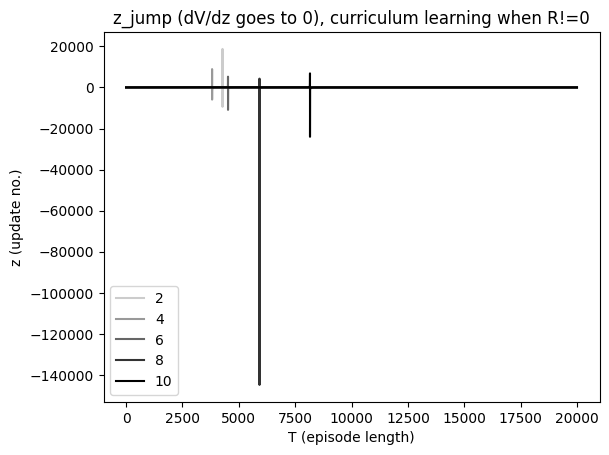

In [10]:
ax1 = plt.subplot(111)
handles = []
for T in [2,4,6,8,10]:
    r = score_dic[T]
    n = iter_dic[T]
    v=V_dynamics4(np.arange(0,20000), VT0, VS0, r, T) 
    #v2=V_dynamics4(np.arange(0,10000), VT0, VS0, r, T)     
    vd=ax1.plot(v, c= 'k', alpha = T* 0.1, label = T)
    #vd=ax1.plot(v2, c= 'k', alpha = T* 0.1, label = T, ls='--')

plt.legend()
ax1.set_title('z_jump (dV/dz goes to 0), curriculum learning when R!=0')
ax1.set_xlabel('T (episode length)')
ax1.set_ylabel('z (update no.)')

In [14]:
args

{'input_dim': 1000,
 'num_tasks': 4,
 'seq_length': 8,
 'simulation': 1,
 'ode': 1,
 'max_iters': [500000, 200000],
 'lr_ws': [1.0, 1.0],
 'vs': [0.25, 0.25, 0.25, 0.25],
 'w_angle': 1.55,
 'lr_v': 1.0,
 'logdir': 'hrl_ode_logs/051223_curriculum_training_time_controlled_vs/',
 'seeds': 3}

1 4710 [0.63476129] [0.63476129] [0.63476544 0.63476544]
2 6067 [0.77347155] [0.77347155] [0.77347569 0.77347569]
4 8723 [0.86696458] [0.86696458] [0.86696593 0.86696593]
6 11976 [0.90356941] [0.90356941] [0.90357239 0.90357239]
8 16262 [0.92322088] [0.92322088] [0.9232209 0.9232209]
10 22084 [0.93551863] [0.93551863] [0.93552039 0.93552039]


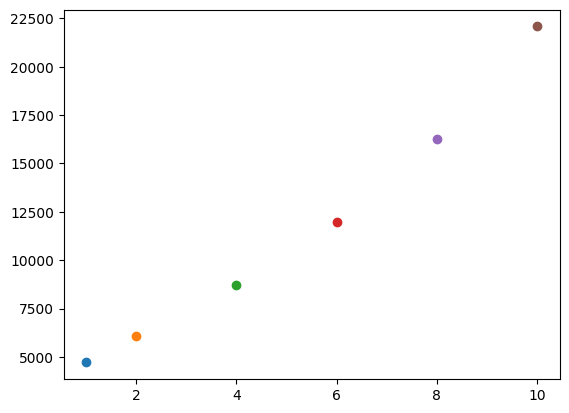

In [3]:
score_dic={}
iter_dic={}
ax1 = plt.subplot(1,1,1)
for p in glob.glob('hrl_ode_logs/051223_curriculum_training_time_controlled_vs/*/'):
    args=json.load(open(os.path.join(p, 'args.json')))
    if args['num_tasks']==2 and args['vs']==[0.9, 0.1]:
        info=jl.load(os.path.join(p, 'ode_0.jl'))
        n=info['composite']['iter']
        print(args['seq_length'], n, info['composite']['threshold'], info['pretraining']['threshold'], info['pretraining']['overlap_task'])
        score_dic[args['seq_length']]= info['pretraining']['threshold']
        iter_dic[args['seq_length']] = n
        ax1.scatter(args['seq_length'], n)


2 100 hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194710.832910/
6 100 hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.222569/
4 100 hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.311107/
8 100 hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.601561/
1 100 hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194712.810711/
10 100 hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194713.696924/


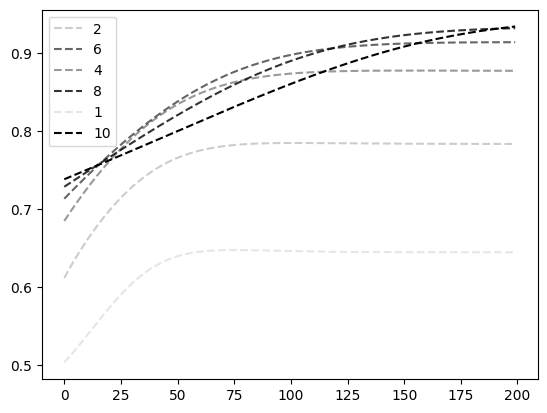

In [107]:
for p in glob.glob('hrl_ode_logs/0612123_curriculum_controlled_VS/*/'):
    args=json.load(open(os.path.join(p, 'args.json')))
    if args['num_tasks']==2 and args['vs']==[0.9, 0.1]:
        print(args['seq_length'],args['update_frequency'],p)
        sim_log, args=load_log(os.path.join(p,'sim_0.jl'))
        ode_log, args =load_log(os.path.join(p,'ode_0.jl'))
        VS_ode = np.concatenate([sim_log['nid']['overlap_tilde'][:int(args['nums_iter'][0]//args['update_frequency'])],
                                              ode_log['nid']['phase2']['overlap_tilde']])
        #plt.plot(VS_sim[3000:])
        plt.plot(VS_ode[3000:3200], ls = '--', label =  args['seq_length'], c = 'black', alpha = args['seq_length']*0.1)
plt.legend()

In [104]:
args

{'input_dim': 1000,
 'num_tasks': 2,
 'seq_length': 8,
 'vt_weights': [1.0, 1.0, 1.0, 1.0],
 'noise_scale': 0.0,
 'nums_iter': [300000, 100000],
 'lr_ws': [1.0, 1.0],
 'vs': [0.5, 0.5],
 'lr_v': 1.0,
 'update_frequency': 100,
 'logdir': 'hrl_ode_logs/0612123_curriculum_controlled_VS/',
 'seeds': 3,
 'v_norm': 0}

In [8]:
glob.glob('hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.601561/*')

['hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.601561/args.json',
 'hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.601561/ode_0.jl',
 'hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.601561/sim_0.jl',
 'hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.601561/ode_1.jl',
 'hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.601561/sim_1.jl',
 'hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.601561/ode_2.jl',
 'hrl_ode_logs/0612123_curriculum_controlled_VS/20231206194711.601561/sim_2.jl']

/tmp/ipykernel_3178732/2678751216.py:16: RuntimeWarning: invalid value encountered in arccos
  return np.power(1-1/np.pi*np.arccos(rho), T-1)


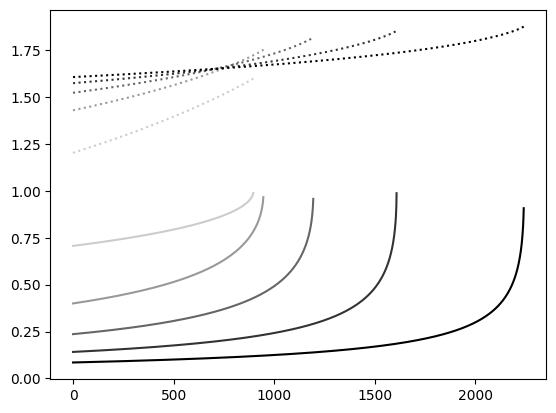

In [55]:
## Looking at two terms!

epochs = 20000

VS0 = [0.9, 0.1]
VS0 /= np.linalg.norm(VS0)
VT0 = [1., 1.]
VT0 /= np.linalg.norm(VT0)
N = 1000



def term1(rho, R):
    return rho + R**2
def term2(rho, T):
    return np.power(1-1/np.pi*np.arccos(rho), T-1)
fig = plt.figure()
ax = plt.subplot(1,1,1)

for T in [2,4,6,8,10]:
    R = score_dic[T]
    rho = np.dot(VS0, VT0) * R
    term1_list = []
    term2_list = []

    for t in range(epochs):
        z1= term1(rho,R)
        z2 = term2(rho, T)
        term1_list.append(z1.item())
        term2_list.append(z2.item())
        rho += z1*z2/np.sqrt(2*np.pi)/N

    ax.plot(term1_list, color = 'k', alpha = 0.1*T, ls = 'dotted')
    ax.plot(term2_list, color = 'k', alpha = 0.1*T)

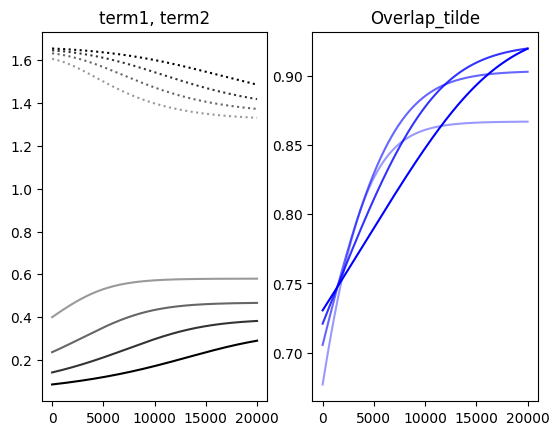

In [14]:
## Looking at two terms!

epochs = 20000

VS0 = np.array([0.9, 0.1], dtype = np.float64)
VS0 /= np.linalg.norm(VS0)
VT0 = np.array([1., 1.], dtype = np.float64)
VT0 /= np.linalg.norm(VT0)
N = 1000


def term1V(VS, VT,  R):
    return VS + VT*R
def term2V(VS, VT, R, T):
    rho = np.dot(VS, VT*R)
    return np.power(1-1/np.pi*np.arccos(rho), T-1)
fig = plt.figure()
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
#ax3 = plt.subplot(1,3,3)

for T in [4,6,8,10]:
    term1V_list = []
    term2V_list = []
    V_list = []
    rho_list = []
    R = score_dic[T]
    VS= VS0.copy()
    VT = VT0.copy()
    for t in range(epochs):
        z1= term1V(VS, VT, R)
        z2 = term2V(VS,VT,R, T)
        term1V_list.append(z1)
        term2V_list.append(z2)
        
        rho_list.append(np.dot(VS, VT*R))
        VS += z1*z2/np.sqrt(2*np.pi)/N
        VS /= np.linalg.norm(VS)
        V_list.append(VS.copy())
        

    ax1.plot(np.array(term1V_list)[:,0], color = 'k', alpha = 0.1*T, ls = 'dotted')
    ax1.plot(term2V_list, color = 'k', alpha = 0.1*T)
    ax2.plot(rho_list, alpha = 0.1*T, color = 'blue')

    ax1.set_title('term1, term2')
    ax2.set_title('Overlap_tilde')
    #ax3.plot(np.array(V_list)[:,0], color = 'orange', alpha = 0.1*T)
    #plt.xscale('log')

4 [2005.68445351]
6 [2623.48011677]
8 [3632.45613106]
10 [5198.86630837]


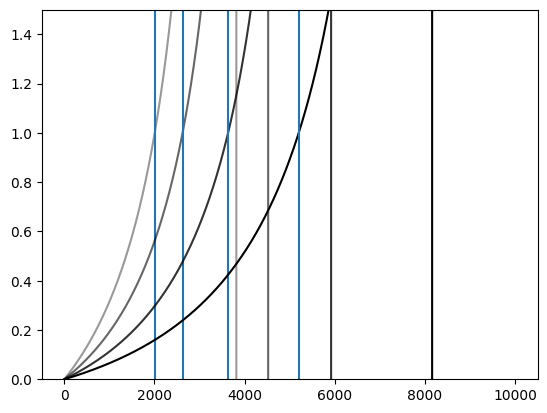

In [234]:
def V_timescale_new(tlist, VS0, VT0,R, T, N =1000):
    ## constant 1st term
    rho0 = np.dot(VS0, VT0)*R
    gamma = 1/np.sqrt(2*np.pi)/N
    alpha = 1- 1/np.pi*np.arccos(rho0)
    beta = 1/np.pi/np.sqrt(1-rho0**2)
    a = gamma*np.power(alpha, T-1)
    b = R**2 + rho0
    c = -beta/alpha
    V_list = []
    for t in tlist:
        V_list.append(1/c*(1-np.power(1-a*b*c*(2-T)*t, 1/(2-T))))
    return V_list
def V_timescale_new2(tlist, VS0, VT0, R, T, N = 1000):
    ## two linear terms
    rho0 = np.dot(VS0, VT0)*R
    gamma = 1/np.sqrt(2*np.pi)/N
    alpha = 1- 1/np.pi*np.arccos(rho0)
    beta = 1/np.pi/np.sqrt(1-rho0**2)

    a = gamma * np.power(alpha, T-1)
    b = rho0 + R**2
    c = (T-1)*beta/alpha
    V_list = []
    for t in tlist:
        y = np.exp(a*t*(1-b*c))
        V_list.append(b*(y-1)/(1-b*c*y))
    return V_list
def critical_time2(VS0, VT0, R, T, N = 1000):
    rho0 = np.dot(VS0, VT0)*R
    gamma = 1/np.sqrt(2*np.pi)/N
    alpha = 1- 1/np.pi*np.arccos(rho0)
    beta = 1/np.pi/np.sqrt(1-rho0**2)

    a = gamma * np.power(alpha, T-1)
    b = rho0 + R**2
    c = (T-1)*beta/alpha

    return  1/(1-b*c)/a * np.log((1/b+1)/(1+c))
VS0 = [0.9, 0.1]
VS0 /= np.linalg.norm(VS0)
VT0 = [1., 1.]
VT0 /= np.linalg.norm(VT0)
for T in [4,6,8,10]: 
    R= score_dic[T]
    #Vlist = V_timescale_new(np.arange(10000),VS0, VT0,R, T )
    Vlist2 = V_timescale_new2(np.arange(10000),VS0, VT0,R, T )
    tau = critical_time2(VS0, VT0, R, T)
    print(T,tau)
    #plt.plot(Vlist, alpha = 0.1*T, c = 'k')
    plt.plot(Vlist2, alpha = 0.1*T, c = 'k')
    plt.axvline(tau)
    plt.ylim(0, 1.5)


1 4710 [0.63476129] [0.63476129] [0.63476544 0.63476544]
2 6067 [0.77347155] [0.77347155] [0.77347569 0.77347569]
4 8723 [0.86696458] [0.86696458] [0.86696593 0.86696593]
6 11976 [0.90356941] [0.90356941] [0.90357239 0.90357239]
8 16262 [0.92322088] [0.92322088] [0.9232209 0.9232209]
10 22084 [0.93551863] [0.93551863] [0.93552039 0.93552039]


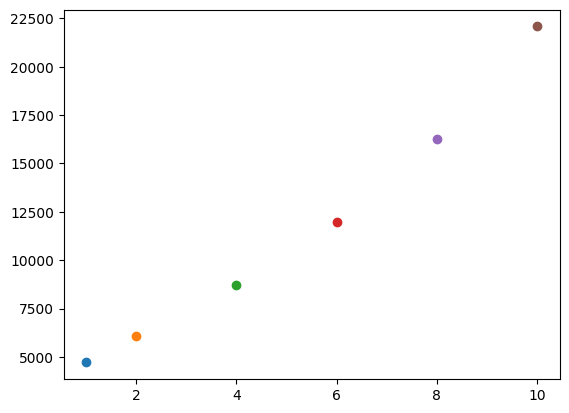

In [233]:
score_dic={}
iter_dic={}
ax1 = plt.subplot(1,1,1)
for p in glob.glob('hrl_ode_logs/051223_curriculum_training_time_controlled_vs/*/'):
    args=json.load(open(os.path.join(p, 'args.json')))
    if args['num_tasks']==2 and args['vs']==[0.9, 0.1]:
        info=jl.load(os.path.join(p, 'ode_0.jl'))
        n=info['composite']['iter']
        print(args['seq_length'], n, info['composite']['threshold'], info['pretraining']['threshold'], info['pretraining']['overlap_task'])
        score_dic[args['seq_length']]= info['pretraining']['threshold']
        iter_dic[args['seq_length']] = n
        ax1.scatter(args['seq_length'], n)

Text(0.5, 1.0, 'Compositional overlap during post-tuning')

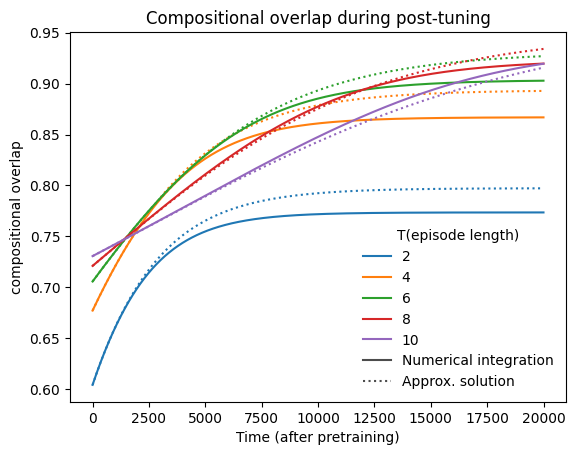

In [40]:
from matplotlib.lines import Line2D
def term1V(VS, VT,  R):
    return VS + VT*R
def term2V(VS, VT, R, T):
    rho = np.dot(VS, VT*R)
    return np.power(1-1/np.pi*np.arccos(rho), T-1)

def rho_lagrnagian(tlist, VS0, VT0, T,  R, N = 1000):
    rho_list = []
    rho0 = np.dot(VS0, VT0)*R
    alpha = 1-np.arccos(rho0)/np.pi
    beta = 1/np.pi/np.sqrt(1-rho0**2)
    gamma = 1/np.sqrt(2*np.pi)/N
    delta_sq = np.sum(VS0**2)*R**2
    epsilon = (T-1)*beta/alpha
    m = delta_sq + rho0**2
    n = 1-epsilon*rho0
    a = -2*rho0/m
    b = epsilon/n
    c1 = (1+rho0*b)/(1+a*rho0)
    for t in tlist:
        y = np.exp((b-a)*gamma*np.power(alpha, T-1)*m*n*t)
        rho_list.append((c1*y-1)/(b-a*c1*y))
    return rho_list

epochs = 20000

VS0 = [0.9, 0.1]
VS0 /= np.linalg.norm(VS0)
VT0 = [1., 1.]
VT0 /= np.linalg.norm(VT0)
N = 1000

handles = []

line = Line2D([0], [0], label='Numerical integration', color='k', alpha = 0.7)
dotted_line = Line2D([0], [0], label='Approx. solution', color='k', ls = 'dotted', alpha = 0.7 )


fig = plt.figure()
ax1 = plt.subplot(111)
for i, T in enumerate([2,4,6,8,10]):
    R = score_dic[T]
    rho_list_lagrangian = rho_lagrnagian(np.arange(epochs), VS0, VT0, T, R)
    rho_list =[]
    VS= VS0.copy()
    VT = VT0.copy()
    for t in range(epochs):
        z1= term1V(VS, VT, R)
        z2 = term2V(VS,VT,R, T)
        VS += z1*z2/np.sqrt(2*np.pi)/N
        VS /= np.linalg.norm(VS)
        rho_list.append(np.dot(VS, VT*R))
    ax1.plot(rho_list_lagrangian, c = f'C{i}', ls = 'dotted')
    l, =ax1.plot(rho_list, c= f'C{i}', label = T)
    handles.append(l)
handles.extend([line, dotted_line])
ax1.legend(handles=handles, title = 'T(episode length)', frameon=False)
#plt.xscale('log')
#plt.xlim(1000,epochs)
## Looking at two terms!
plt.ylabel('compositional overlap')
plt.xlabel('Time (after pretraining)')
plt.title('Compositional overlap during post-tuning')


Text(0.5, 1.0, 'K=2 ([0.9,0.1]-> [1.0,1.0]), V alignment time after primitive pre-training')

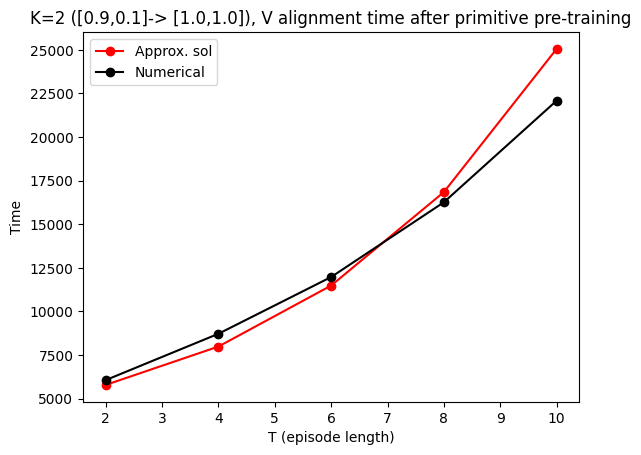

In [33]:
epochs =30000
approx = []
TS=[2,4,6,8,10]
for i, T in enumerate(TS):
    R = score_dic[T]
    rho_list_lagrangian = rho_lagrnagian(np.arange(epochs), VS0, VT0, T, R)
    approx.append(np.where(rho_list_lagrangian > R)[0][0])

plt.plot(TS, approx,'-o', c= 'red', label = 'Approx. sol')
plt.plot(TS, [iter_dic[T] for T in TS], '-o', c= 'black', label = 'Numerical')
plt.legend()
plt.xlabel('T (episode length)')
plt.ylabel('Time')
plt.title('K=2 ([0.9,0.1]-> [1.0,1.0]), V alignment time after primitive pre-training')

In [22]:
iter_dic

{1: 4710, 2: 6067, 4: 8723, 6: 11976, 8: 16262, 10: 22084}

In [23]:
approx

[7990, 11487, 16846, 25051]